In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
import time


%matplotlib notebook
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from tqdm.auto import tqdm

from utils import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
import psutil
psutil.cpu_count()

8

In [3]:
NTHREADS = psutil.cpu_count()-1
SEED = 42
BUCKET_WINDOWS2 = [(0, 100), (100, 200), (200, 300), (300, 400), (400, 500), (500, 600)]

DATA_PATH = '../input/optiver-realized-volatility-prediction'
BOOK_TRAbIN_PATH = '../input/optiver-realized-volatility-prediction/book_train.parquet'
TRADE_TRAIN_PATH = '../input/optiver-realized-volatility-prediction/trade_train.parquet'
BOOK_TEST_PATH = '../input/optiver-realized-volatility-prediction/book_test.parquet'
TRADE_TEST_PATH = '../input/optiver-realized-volatility-prediction/trade_test.parquet'
CHECKPOINT = 'model_checkpoint/model_01'

book_skip_columns = trade_skip_columns = ['time_id', 'row_id', 'target']

In [4]:
import pickle
data_input = open('../LSTMtemp/np_train.pkl','rb')
np_train = pickle.load(data_input)
data_input.close()

data_input = open('../LSTMtemp/targets.pkl','rb')
targets = pickle.load(data_input)
data_input.close()

f = open('Realized_vol.pkl', 'rb')
Realized_vol = pickle.load(f)
f.close()

In [5]:
idx = np.arange(np_train.shape[0])
train_idx, valid_idx = train_test_split(idx, shuffle=False, test_size=0.1, random_state=2021)

In [6]:
# Loss function
def rmspe(y_true, y_pred):
    return torch.sqrt(torch.mean(torch.square((y_true - y_pred) / y_true)))

In [7]:
class Myloss(nn.Module):
    def __init__(self):
        super(Myloss, self).__init__()
    
    def forward(self, y_true, y_pred):
        x = torch.sqrt(torch.mean(torch.square((y_true - y_pred) / y_true)))
        return x

In [8]:
class MyDataset2():
    def __init__(self, ds, targets, real_vol, batch_size):
        self.ds = ds
        self.y = targets[:,np.newaxis,np.newaxis]
        self.batch_size = batch_size
        self.real_vol = real_vol[:,np.newaxis,np.newaxis]
        self.indexes = np.arange(self.ds.shape[0])
        self.index = 0
        
        
    def __getitem__(self, i):
        batch_index = self.indexes[i * self.batch_size : (i + 1) * self.batch_size]
        X = self.ds[batch_index]
        Y = self.y[batch_index]
        R = self.real_vol[batch_index]
        return X, Y, R
    
    def __call__(self, i):
        batch_index = self.indexes[i * self.batch_size : (i + 1) * self.batch_size]
        X = self.ds[batch_index]
        Y = self.y[batch_index]
        X = torch.from_numpy(X)
        Y = torch.from_numpy(Y)
        R = self.real_vol[batch_index]
        R = torch.from_numpy(R)
        return X, Y, R
    
    def __len__(self):
        return int(np.ceil(self.ds.shape[0] / self.batch_size))
    
    def next_item(self):
        if self.index >= self.__len__():
            self.index = 0
        X, Y, R = self.__getitem__(self.index)
        self.index += 1
        return X, Y, R

In [9]:
assert torch.cuda.is_available()
device = 'cuda'

In [10]:
from models.model import Informer, InformerStack
from utils.tools import EarlyStopping, adjust_learning_rate

In [11]:
# Hyperparams
enc_in = 29
dec_in = 1
c_out = 1 
seq_len = 36
out_len = 1
d_model = 10
d_ff = 10
n_heads = 2
label_len = 1

Batch_size = 256
lr = 0.002

In [12]:
model = Informer(enc_in=enc_in, dec_in=dec_in, c_out=c_out, out_len=out_len,
                d_model=d_model, d_ff=d_ff, n_heads=n_heads, label_len=label_len
                )
model.to(device)

Informer(
  (enc_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(29, 10, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (dec_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(1, 10, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0): EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): ProbAttention(
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (query_projection): Linear(in_features=10, out_features=10, bias=True)
          (key_projection): Linear(in_features=10, out_features=10, bias=True)
          (value_projection): Linear(in_features=10

In [13]:
criterion = Myloss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience=5,factor = 0.2)

In [14]:
Real_vol = Realized_vol['realized_volatility'].values

In [15]:
mytrainloader = MyDataset2(np_train[train_idx, :, :], targets[train_idx], Real_vol[train_idx], Batch_size)
mytestloader =  MyDataset2(np_train[valid_idx, :, :], targets[valid_idx], Real_vol[valid_idx], Batch_size)

In [16]:
def process_one_batch(batch_x, batch_y):
    batch_y = batch_y.float()
    # decoder input
    dec_inp = torch.zeros([batch_y.shape[0], out_len, batch_y.shape[-1]]).float()
    dec_inp = torch.cat([batch_y[:,:label_len], dec_inp], dim=1).float().to(device)
    # encoder - decoder
    outputs = model(batch_x, dec_inp)
    f_dim = 0
    batch_y = batch_y[:,-out_len:,f_dim:].to(device)

    return outputs, batch_y

In [17]:
# Train
train_loss = []
val_loss = []
best_loss = float('+inf')
if hasattr(torch.cuda, 'empty_cache'):
    torch.cuda.empty_cache()

epochs = 100
counter = 0

for epoch in tqdm(range(epochs)):
    model.train()
    avg_loss = []
    for i in range(len(mytrainloader)):
        x, y, r = mytrainloader(i)
        x = x.to(device)
        x = x.float()
        optimizer.zero_grad()
        pred,_ = process_one_batch(x, r)
        y = y.to(device)
        loss = criterion(y,pred)
        avg_loss.append(loss.item())
        loss.backward()
        optimizer.step()
    avg_loss = np.array(avg_loss).mean()
    train_loss.append(avg_loss)
    scheduler.step(avg_loss)
    
    model.eval()
    val_aloss = []
    with torch.no_grad():
        for i in range(len(mytestloader)):
            x,y,r = mytestloader(i)
            x = x.float()
            x = x.to(device)
#             y = y.to(device)
            pred,_ = process_one_batch(x, r)
            y = y.to(device)
            loss = criterion(y, pred)
            val_aloss.append(loss.item())
        val_aloss = np.array(val_aloss).mean()
        val_loss.append(val_aloss)
    
    if val_aloss <best_loss:
        best_loss = val_aloss
        best_epoch = epoch
        torch.save(model.state_dict(), 'informer_model.pt')
        counter = 0
    counter += 1
    print('Epoch:  {}   |Train_Loss: {:.6f} |Val_Loss: {:.6f}'.format(epoch + 1,avg_loss,val_aloss))
    if counter >= 9:
        print('连续{}个epoch没有下降了'.format(counter))

Epoch:  1   |Train_Loss: 3.970819 |Val_Loss: 3.483728
Epoch:  2   |Train_Loss: 2.071244 |Val_Loss: 1.035540
Epoch:  3   |Train_Loss: 1.585138 |Val_Loss: 1.389258
Epoch:  4   |Train_Loss: 1.332666 |Val_Loss: 0.587124
Epoch:  5   |Train_Loss: 1.071279 |Val_Loss: 0.379971
Epoch:  6   |Train_Loss: 1.022516 |Val_Loss: 0.298409
Epoch:  7   |Train_Loss: 0.807379 |Val_Loss: 0.258965
Epoch:  8   |Train_Loss: 0.786860 |Val_Loss: 0.440861
Epoch:  9   |Train_Loss: 0.852135 |Val_Loss: 0.484758
Epoch:  10   |Train_Loss: 0.802562 |Val_Loss: 0.306232
Epoch:  11   |Train_Loss: 0.727938 |Val_Loss: 0.307208
Epoch:  12   |Train_Loss: 0.687485 |Val_Loss: 0.306501
Epoch:  13   |Train_Loss: 0.744328 |Val_Loss: 0.424620
Epoch:  14   |Train_Loss: 0.522035 |Val_Loss: 0.379170
Epoch:  15   |Train_Loss: 0.602377 |Val_Loss: 0.304242
连续9个epoch没有下降了
Epoch:  16   |Train_Loss: 0.532036 |Val_Loss: 0.238659
Epoch:  17   |Train_Loss: 0.565549 |Val_Loss: 0.230357
Epoch:  18   |Train_Loss: 0.526355 |Val_Loss: 0.366132
Epoc

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


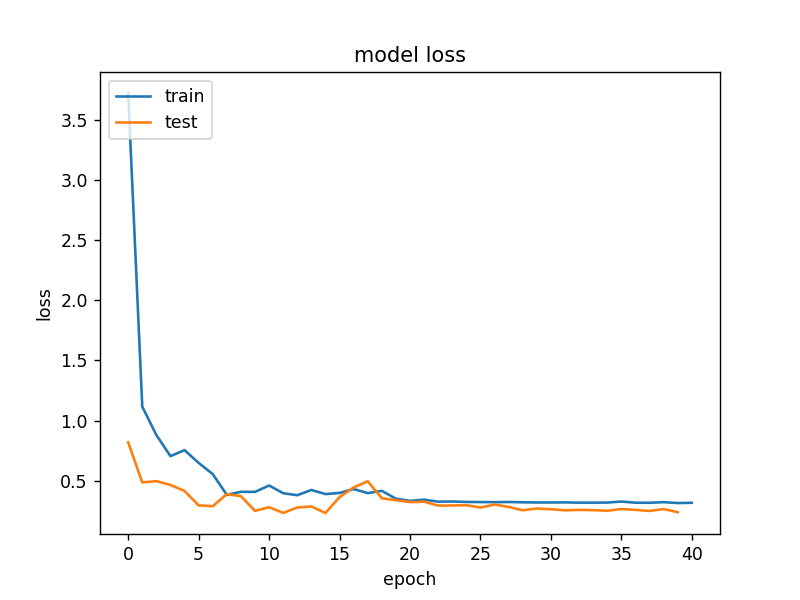

Min val_loss is: 0.23169449823243277 at 14 epoch
The Hyperparameter:
    d_model = 20
    d_ff = 20
    n_heads = 3
    Batch_size = 256
    lr = 0.006
      


In [64]:
import matplotlib.pyplot as plt

plt.plot(train_loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train','test'], loc = 'upper left')
plt.show()
print('Min val_loss is:',best_loss,'at',best_epoch,'epoch')
print("""The Hyperparameter:
    d_model = {}
    d_ff = {}
    n_heads = {}
    Batch_size = {}
    lr = {}
      """.format(d_model, d_ff, n_heads, Batch_size, lr))

<IPython.core.display.Javascript object>


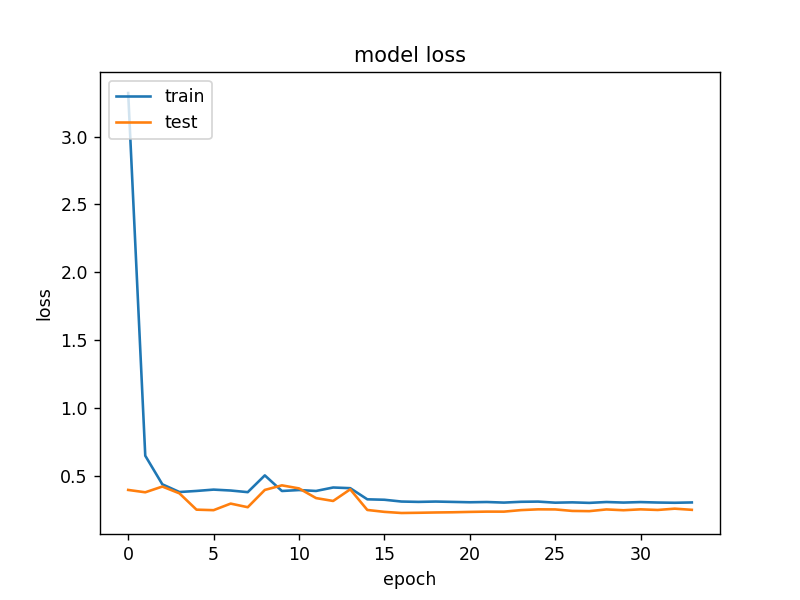

Min val_loss is: 0.22787200739341124 at 16 epoch
The Hyperparameter:
    d_model = 20
    d_ff = 20
    n_heads = 2
    Batch_size = 256
    lr = 0.006
      


In [72]:
import matplotlib.pyplot as plt

plt.plot(train_loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train','test'], loc = 'upper left')
plt.show()
print('Min val_loss is:',best_loss,'at',best_epoch,'epoch')
print("""The Hyperparameter:
    d_model = {}
    d_ff = {}
    n_heads = {}
    Batch_size = {}
    lr = {}
      """.format(d_model, d_ff, n_heads, Batch_size, lr))

In [18]:
def write_log(today,params,train_loss,val_loss):
    
    plt.figure()
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.savefig('log/Model_{}_{}.png'.format('Infomer',today))
    
    f = open('log/Model_{}_{}.txt'.format('Infomer',today),'a+')
    d_model, d_ff, n_heads, Batch_size, lr = params
    f.write('Min val_loss is:{} at {} epoch \n'.format(best_loss, best_epoch))
    f.write("""The Hyperparameter:
    d_model = {} d_ff = {}
    n_heads = {} Batch_size = {} lr = {}
      """.format(d_model, d_ff, n_heads, Batch_size, lr))
    f.close()

<IPython.core.display.Javascript object>


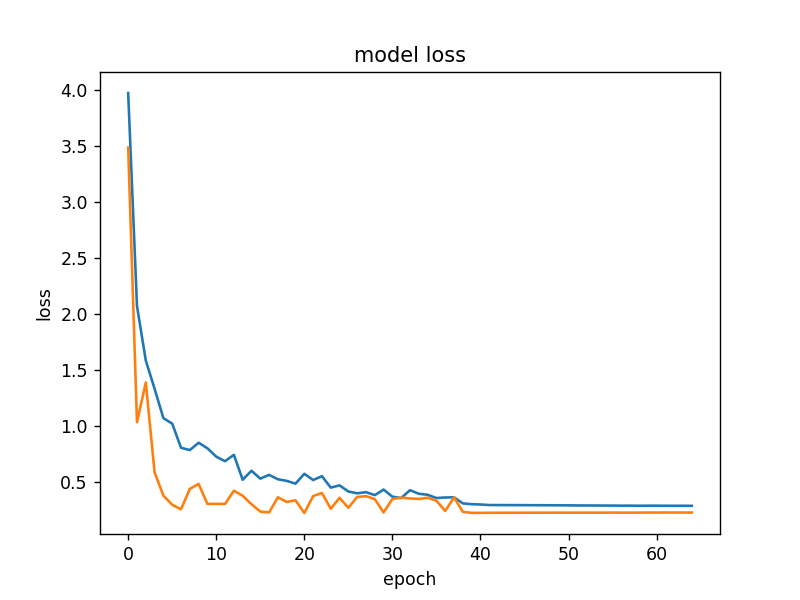

In [19]:
today = time.strftime("%m-%d-%H-%M", time.localtime())
params = [d_model, d_ff, n_heads, Batch_size, lr]
write_log(today,params,train_loss,val_loss)


In [20]:
print('Min val_loss is:',best_loss,'at',best_epoch,'epoch')
print("""The Hyperparameter:
    d_model = {}
    d_ff = {}
    n_heads = {}
    Batch_size = {}
    lr = {}
      """.format(d_model, d_ff, n_heads, Batch_size, lr))

Min val_loss is: 0.22561197328780377 at 20 epoch
The Hyperparameter:
    d_model = 10
    d_ff = 10
    n_heads = 2
    Batch_size = 256
    lr = 0.002
      
